In [2]:
#16 constrained least squares

#1)use the gram-schmidt algorithm
import numpy as np
def gram_schmidt(a):
    q=[]
    for i in range(len(a)):
        #orthogonalization
        q_tilde=a[i]
        for j in range(len(q)):
            q_tilde = q_tilde - (q[j]@a[i])*q[j]
        q_tilde = q_tilde / np.sqrt(sum(q_tilde**2))
        q.append(q_tilde) #此处q[i]代表Q的第i行
    return q

#2)QR factorization
def QR_factorization(A):
    Q_transpose = np.array(gram_schmidt(A.T))
    R = Q_transpose @ A
    Q = Q_transpose.T
    return Q,R

# vandermonde matrix
def vandermonde(t,n):
    m = len(t)
    V = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            V[i,j] = t[i]**(j)
    return V

#5)back substitution
def back_subst(R,b_tilde): #there R is a upper matrix
    n = R.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = b_tilde[i]
        for j in range(i+1,n):
            x[i] = x[i] - R[i,j]*x[j]
        x[i] = x[i]/R[i,i]
    return x

#6)solving system of linear equations, here x is the pseudo-matrix.
def solve_via_backsub(A,b):
    Q,R = QR_factorization(A)
    b_tilde = Q.T @ b
    x= back_subst(R,b_tilde)
    return x


#16.2 solution 
#forming the KKT matrix and solve it
def cls_solve_kkt(A,b,C,d):
    m,n = A.shape
    p,n = C.shape
    #gram matrix
    G = A.T @ A
    #kkt matrix
    KKT = np.vstack([np.hstack([2*G,C.T]),np.hstack([C,np.zeros((p,p))])])
    xzhat = solve_via_backsub(KKT,np.hstack([2*A.T@b,d]))
    return xzhat[:n]

#solving constrained least squares via QR
import numpy as np
def cls_solve(A,b,C,d):
    m,n = A.shape
    p,n = C.shape
    Q,R = np.linalg.qr(np.vstack([A,C]))
    Q1 = Q[:m,:]
    Q2 = Q[m:,:]
    Qtil,Rtil = np.linalg.qr(Q2.T)
    w = solve_via_backsub(Rtil,(2*Qtil.T@Q1.T@b-2*solve_via_backsub(Rtil.T,d)))
    xhat = solve_via_backsub(R,(Q1.T@b-Q2.T@w/2))
    return xhat

#Sparse constrained least sqaures
def cls_solve_sparse(A,b,C,d):
    m,n = A.shape
    p,n = C.shape
    bigA = np.vstack([np.hstack([np.zeros((n,n)),A.T,C.T]),
                                 np.hstack([A,-np.eye(m)/2,np.zeros((m,p))]),
                                 np.hstack([C,np.zeros((p,m)),np.zeros((p,p))])])
    xyzhat = solve_via_backsub(bigA,np.hstack([np.zeros(n),b,d]))
    xhat = xyzhat[:n]
    return xhat

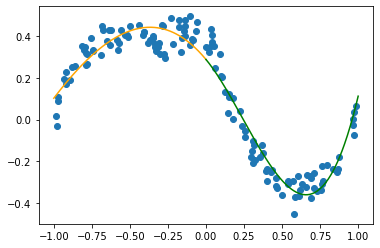

In [3]:
#piecewise polynomial: here we take a=0
M = 70
N = 2*M
xleft = np.random.random(M) - 1
xright = np.random.random(M)
x = np.hstack([xleft,xright])
y = np.power(x,3) - x + 0.4/(1+25*np.power(x,2)) + 0.05*np.random.normal(size = N)
n = 4
A = np.vstack([np.hstack([vandermonde(xleft,n),np.zeros((M,n))]),np.hstack([np.zeros((M,n)),vandermonde(xright,n)])])
b = y
C = np.vstack((np.hstack([1,np.zeros(n-1),-1,np.zeros(n-1)]),np.hstack([0,1,np.zeros(n-2),0,-1,np.zeros(n-2)])))
d = np.zeros(2)
theta = cls_solve(A,b,C,d)

import matplotlib.pyplot as plt
plt.ion()
#Evaluate and plot for 200 equidistant point on each side.
Npl = 200
x_left = np.linspace(-1,0,Npl)
y_left = vandermonde(x_left,4) @ theta[:n]
x_right = np.linspace(0,1,Npl)
y_right = vandermonde(x_right,4) @ theta[n:]
plt.scatter(x,y)
plt.plot(x_left,y_left,'orange')
plt.plot(x_right,y_right,'green')
plt.show()

In [4]:
#advertising budget
n = 3
m = 10
R = np.array([[0.97,1.86,0.41], [1.23,2.18,0.53],
              [0.80,1.24,0.62], [1.29,0.98,0.51], [1.10,1.23,0.69],
              [0.67,0.34,0.54], [0.87,0.26,0.62], [1.10,0.16,0.48],
              [1.92,0.22,0.71], [1.29,0.12,0.62]])
print(cls_solve(R,1e3*np.ones(m),np.ones((1,n)),np.array([1284])))

#Minimum norm force sequence
A = np.eye(10)
b = np.zeros(10)  #the sum of squares of the force
C = np.vstack([np.ones((1,10)),np.arange(9.5,0.4,-1).T])
d = np.array([0,1])
print(cls_solve(A,b,C,d))

#solving the KKT form
A = np.random.normal(size = (10,5))
b = np.random.normal(size = 10)
C = np.random.normal(size = (2,5))
d = np.random.normal(size = 2)
x = cls_solve_kkt(A,b,C,d)
#check that residual iss small
print(C@x - d)

[315.16818459 109.86643348 858.96538193]
[ 0.05454545  0.04242424  0.03030303  0.01818182  0.00606061 -0.00606061
 -0.01818182 -0.03030303 -0.04242424 -0.05454545]
[6.66133815e-16 9.00945984e-14]


In [5]:
#16.3 solving constrained least sqaures via QR
# compare with KKT method
m = 10
n = 5
p = 2
A = np.random.normal(size = (m,n))
b = np.random.normal(size = m)
C = np.random.normal(size = (p,n))
d = np.random.normal(size = p)
xKKT = cls_solve_kkt(A,b,C,d)
xQR = cls_solve(A,b,C,d)
#compare solutions
print(np.linalg.norm(xKKT-xQR))

#example of sparse matrix
m = 100
n = 50
p = 10
A = np.random.normal(size = (m,n))
b = np.random.normal(size = m)
C = np.random.normal(size = (p,n))
d = np.random.normal(size = p)
x1 = cls_solve(A, b, C, d)
x2 = cls_solve_sparse(A, b, C, d)
# compare solutions
print(np.linalg.norm(x1 - x2))

#solving least norm problem
p = 50
n = 500
C = np.random.normal(size = (p,n))
d = np.random.normal(size = p)
#solve via least norm analytical solution
x1 = C.T @ np.linalg.inv(C @ C.T) @ d
#solve using cls_solve which uses KKT
x2 = cls_solve(np.eye(n),np.zeros(n),C,d)
#using pseudo inverse
x3 = np.linalg.pinv(C) @ d
print(np.linalg.norm(x1-x2))
print(np.linalg.norm(x1-x3))
print(np.linalg.norm(x3-x2))

9.011333963579735e-15
8.046830286441121e-14
3.6236660881678586e-15
7.622900260779644e-16
3.686587734846224e-15


[-3.84592537e-16 -9.27672104e-16  1.83333333e+00  3.33333333e-01
 -1.16666667e+00]


C:\Users\15829\AppData\Local\Temp\ipykernel_9896\2832978600.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(x,x_1@theta)


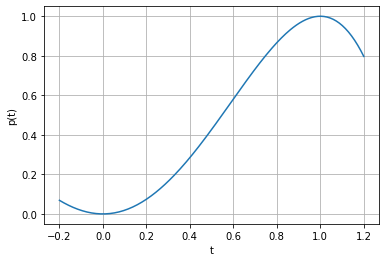

In [14]:
#exercise 16.12 Least norm polynomial interpolation
A = np.eye(5) 
b = np.zeros(5)
C = np.vstack([np.hstack([1,np.zeros(4)]),np.hstack([0,1,np.zeros(3)]),np.ones(5),np.hstack([0,1,2,3,4])])
d = np.array([0,0,1,0])
theta = cls_solve(A,b,C,d)
print(theta)

import matplotlib.pyplot as plt
plt.ion()
x = np.linspace(-0.2,1.2,200)
x_1 = [1,x,x**2,x**3,x**4]
plt.plot(x,x_1@theta)
plt.grid()
plt.xlabel('t')
plt.ylabel('p(t)')
plt.show()

10650.985305383945 10624.59130571181


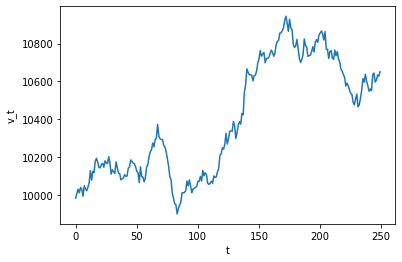

In [8]:
#17 Constrained least sqaures applications
#17.1 Portfolio optimization
# we form the cumulative product of the vector with entries 1+rt with the function np.cumprod()
import numpy as np
cum_value = lambda r:10000*np.cumprod(1+r)
T = 250
#Generate random returns sequence with 10% annualized return, 5% annualized risk
mu = 0.10/250
sigma = 0.05/np.sqrt(250)
r = mu + sigma*np.random.normal(size = T)
v = cum_value(r)
#compute final value and average return
print(v[T-1],v[0]*(1+sum(r)))

import matplotlib.pyplot as plt
plt.ion()
plt.plot(np.arange(T),v)
plt.xlabel('t')
plt.ylabel('v_t')
plt.show()


In [9]:
#Portfolio optimization
def port_opt(R,rho):
    T,n = R.shape
    mu = np.sum(R,axis = 0).T/T
    KKT = np.vstack([np.column_stack([2*R.T@R,np.ones(n),mu.T]),np.hstack([np.ones(n).T,0,0]),np.hstack([mu,0,0])])
    wz1z2 = solve_via_backsub(KKT,np.hstack([2*rho.T*mu,1,rho]))
    w = wz1z2[:n]
    return w

R,Rtest = portfolio_data()
T,n = R.shape
rho = 0.1/250 # ask for 10% annual return
w = port_opt(R,rho)
r = R @ w # portfolio return time series
pf_return = 250*sum(r)/len(r)
pf_risk = np.sqrt(T)*np.std(r)
print(pf_return)
print(pf_risk)

import matplotlib.pyplot as plt
plt.ion()
cum_value = lambda r: 10000*np.cumprod(1+r)
# 10% annual return
rho = 0,1/250
w = proy_opt(R,rho)
r = R @ w
plt.plot(np.arange(T),cum_value(r),'blue')

FileNotFoundError: [Errno 2] No such file or directory: 'portfolio_data.csv'

In [ ]:
#17.2 linear quadratic control
#Kronecker product:use the function 'np.kron(G,H)'
H = np.random.normal(size = (2,2))
print(np.kron(np.eye(3),H))






















